Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import ast # used to convert strings to lists
import time
from rapidfuzz import process, fuzz

We can pick what we consider to be a franchise. At the moment, any franchise that is smaller than the number below will be excluded. We'll also set the value for our best_fit_ratio. At this stage, you won't know what it is, but having it here, allows us to easily change it later if necessary

In [431]:
minimum_franchise_value = 3
considered_best_fit_ratio = 92.5

First, read in the imdb data and the giantbomb data as dataframes and get a count

In [2]:
imdb_games = pd.read_csv("imdb_games_db.csv", index_col = 0)
giantbomb_games = pd.read_csv("clean_giantbomb_games_db.csv", index_col = 0)

In [3]:
print("Total imdb_games: {} \nTotal giantbomb_games: {}".format(imdb_games.shape[0], giantbomb_games.shape[0]))

Total imdb_games: 14435 
Total giantbomb_games: 35117


We'll remove any exact duplicates from both dataframes

In [4]:
imdb_games = imdb_games.drop_duplicates()
giantbomb_games = giantbomb_games.drop_duplicates()
print("Total imdb_games: {} \nTotal giantbomb_games: {}".format(imdb_games.shape[0], giantbomb_games.shape[0]))

Total imdb_games: 14435 
Total giantbomb_games: 35116


Have a look at what our dataframes contain:

In [5]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas
303923,tt0317518,videoGame,Football,Football,0,1978,\N,\N,"Family,Sport",3.9,24.0,['Football']


In [6]:
giantbomb_games.sample()

,franchise_id,game_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
6502,3025-173,458,X-Men: Wolverine's Rage,NaN,NaN,"['Digital Eclipse Software, Inc.']","['Action', 'Platformer']",['Game Boy Color'],['Activision'],['ESRB: E']


### Remove imdb duplicates

We want to remove any duplicates from our imdb data that contain the same name and year. We save the one with the highest number of votes

In [7]:
imdb_games = imdb_games.sort_values(by=["primaryTitle", "startYear", "numVotes"])
imdb_games = imdb_games.drop_duplicates(subset=["primaryTitle", "startYear"], keep="last")
imdb_games.tconst.count()

14384

In [8]:
imdb_games.primaryTitle[imdb_games.duplicated(["primaryTitle", "startYear"], keep=False)].count()

0

### Remove giantbomb duplicates

As each game_id is unique, we want to group all the franchises for each game into a single result for each game_id. First though we check whether any of the the rows have the same game_id but a different name or release_year

In [9]:
giantbomb_games.count()

franchise_id    35116
game_id         35116
name            35116
release_year     5435
aliases          8088
developers      32746
genres          33660
platforms       34802
publishers      33604
rating          14184
dtype: int64

In [10]:
print(giantbomb_games.groupby("game_id").filter(lambda x: x["name"].nunique() > 1 or x["release_year"].nunique() > 1)["game_id"].count())

0


The next thing will be to remove any franchises which only contain 1 or 2 entries. Though they may technically count as a franchise, they do nothing to help us with analysis on the basis of longevity so we'll treat them as if they don't belong in a franchise

In [11]:
giantbomb_games.game_id.count()

35116

In [12]:
# Note: minimum_franchise_value is set at the top of the notebook
franchise_counts = giantbomb_games.groupby('franchise_id').size()
franchise_dict = {k:v for k,v in franchise_counts.items() if v < minimum_franchise_value}
franchise_ids_to_drop = list(franchise_dict.keys())

mask = giantbomb_games['franchise_id'].isin(franchise_ids_to_drop)
giantbomb_games = giantbomb_games.drop(index=giantbomb_games[mask].index)

In [13]:
giantbomb_games.count()

franchise_id    31529
game_id         31529
name            31529
release_year     4668
aliases          7423
developers      29402
genres          30205
platforms       31251
publishers      30282
rating          13149
dtype: int64

The first thing to do is to combine all the games that have an identical franchise_id, release_year and name. With this criteria we will assume they are all the same game released on different platforms for example. We want to consider the release_year even when it is a nan value, so we convert all nan values to 0 accommodate this. Once we've done this, we group by game_id to combine the franchises for each individual game

In [14]:
giantbomb_games = giantbomb_games.groupby(["name", "franchise_id", giantbomb_games["release_year"].fillna(0)]).agg({
    "aliases": lambda x: list(set(x)),
    "developers": lambda x: list(set(x)),
    "genres": lambda x: list(set(x)),
    "platforms": lambda x: list(set(x)),
    "publishers": lambda x: list(set(x)),
    "rating": lambda x: list(set(x)),
    "game_id": "first"
}).reset_index().drop_duplicates(["game_id", "name", "franchise_id", "release_year"], keep="first")

giantbomb_games = giantbomb_games.groupby('game_id').agg({
    'franchise_id': lambda x: list(x),
    'name': 'first',
    'release_year': 'first',
    'aliases': 'first',
    'developers': 'first',
    'genres': 'first',
    "platforms": "first",
    "publishers" : "first",
    "rating": "first"
})

# Change year to string to match imdb database
giantbomb_games["release_year"] = giantbomb_games["release_year"].apply(lambda x : str(x).split('.')[0])

In [15]:
giantbomb_games.sort_values("game_id")

,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
game_id,,,,,,,,,
1,"[3025-143, 3025-2573]",Desert Strike: Return to the Gulf,1992,[Desert Strike Advance],"[['Electronic Arts', 'Visual Concepts', 'Budca...","[['Action', ""Shoot 'Em Up""]]","[['Amiga', 'Game Boy', 'Game Boy Advance', 'Ga...","[['Electronic Arts', 'Domark Software', 'Malib...","[['ESRB: K-A', 'ESRB: E']]"
3,[3025-2060],Hyperballoid Deluxe: Survival Pack,0,[nan],[['Kernel Kaput']],"[['Action', 'Block-Breaking']]",[['PC']],"[['Alawar Entertainment, Inc.']]",[nan]
4,[3025-1110],The Chessmaster 2000,1986,[nan],"[['The Software Toolworks', 'Software Country'...","[['Strategy', 'Trivia/Board Game']]","[['Amiga', 'Amstrad CPC', 'Apple II', 'Atari S...","[['The Software Toolworks', 'Software Country'...",[nan]
6,"[3025-128, 3025-130, 3025-1372]",WWE SmackDown! vs. RAW 2007,0,[SVR 2007],"[[""Yuke's Co. Ltd."", 'Digital Hearts Co., Ltd....","[['Action', 'Sports', 'Wrestling']]","[['PlayStation Portable', 'PlayStation 2', 'Xb...",[['THQ']],"[['ESRB: T', 'PEGI: 16+', 'CERO: C']]"
8,[3025-335],Super Spy Hunter,0,[Battle Formula],[['Tokai Engineering']],[['Vehicular Combat']],[['Nintendo Entertainment System']],[['Sunsoft']],[nan]
...,...,...,...,...,...,...,...,...,...
88822,[3025-2291],Winning Post 10,0,[nan],[nan],[['Driving/Racing']],"[['PC', 'PlayStation 4', 'Nintendo Switch', 'P...",[['Koei Tecmo']],[['CERO: A']]
88824,[3025-5696],Wan Nyan Dōbutsu Byōin,0,[nan],[nan],[['Simulation']],[['Game Boy Advance']],[['TDK Core']],[['CERO: All Ages']]
88831,[3025-5699],Shogi Saikyou: Pro ni Manabu,0,[nan],[['Magical Company']],[['Trivia/Board Game']],[['PlayStation']],[['Magical Company']],[nan]


We can now get a record of the number of duplicate names in the data

In [16]:
giantbomb_games.name[giantbomb_games.duplicated(["name"], keep=False)].count()

560

We can add the criteria to distinguish by both name and release year, which returns the following:

In [17]:
giantbomb_games.name[giantbomb_games.duplicated(["name", "release_year"], keep=False)].count()

72

We'll combine any duplicates in giantbomb which have the same name and release year

In [18]:
# group by name and release year, aggregate the franchise_id lists
giantbomb_games = giantbomb_games.groupby(['name', 'release_year'], as_index=False).agg({
    'franchise_id': lambda x: list(set([i for l in x for i in l])),
    'name': 'first',
    'release_year': 'first',
    "aliases": 'first',
    "developers": lambda x: list(set([i for l in x for i in l])),
    "genres": lambda x: list(set([i for l in x for i in l])),
    "platforms": lambda x: list(set([i for l in x for i in l])),
    "publishers" : lambda x: list(set([i for l in x for i in l])),
    "rating": lambda x: list(set([i for l in x for i in l]))
})

The release year needs to be converted to a string so we can compare it to the imdb database. We also need to tmove trailing decimal points.

In [19]:
giantbomb_games["release_year"] = giantbomb_games["release_year"].apply(lambda x : str(x).split('.')[0])

Reset the index so we have access to the game_ids

In [20]:
giantbomb_games = giantbomb_games.reset_index()
giantbomb_games = giantbomb_games.rename(columns={'index': 'game_id'})

In [21]:
giantbomb_games.sample()

,game_id,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
14967,14967,[3025-3081],Ordyne,0,[nan],[['Namco']],"[[""Shoot 'Em Up""]]","[['PlayStation', 'TurboGrafx-16', 'Arcade', 'W...","[['Bandai Namco Entertainment', 'Namco', 'NEC ...","[['ESRB: E', 'CERO: A']]"


## Beginning to combine dataframes

In [24]:
def imdb_all_names(imdb_row):
    imdb_row_list = [imdb_row.primaryTitle, imdb_row.originalTitle]
    if type(imdb_row.akas) ==str:
        akas_list = ast.literal_eval(imdb_row.akas)
        for x in akas_list:
            imdb_row_list.append(x)
    return imdb_row_list

Create a row with all the possible names

In [25]:
imdb_games['all_names'] = imdb_games.apply(lambda row: imdb_all_names(row), axis=1)


Remove duplicates from all names and explode

In [26]:
imdb_games['all_names'] = imdb_games['all_names'].apply(lambda x: list(set(x)))

In [27]:
imdb_games = imdb_games.explode('all_names')

Do the same for giantbomb

In [28]:
def gb_all_names(gb_row):
    gb_row_list = [gb_row["name"]]
    for alias in gb_row.aliases:
        if type(alias) == str:
            gb_row_list.append(alias) 
    return gb_row_list

In [29]:
giantbomb_games['all_names'] = giantbomb_games.apply(lambda row: gb_all_names(row), axis=1)
giantbomb_games['all_names'] = giantbomb_games['all_names'].apply(lambda x: list(set(x)))

In [30]:
giantbomb_games = giantbomb_games.explode("all_names")
giantbomb_games_list = giantbomb_games.all_names.to_list()

In [31]:
def get_top_matches(imdb_row):
    return process.extract(imdb_row.all_names, giantbomb_games_list, limit = 3)

In [35]:
time_at_start = time.perf_counter()
imdb_games['best_matches'] = imdb_games.apply(lambda row: get_top_matches(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

4590.877031399999


In [37]:
def best_fit(row):
    highest = 0
    best_match = ()
    for match in row["best_matches"]:
        if match[1] > highest:
            highest = match[1]
            best_match = match
    return best_match
imdb_games['best_fit'] = imdb_games.apply(lambda row: best_fit(row), axis = 1)

In [38]:
imdb_games[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = imdb_games['best_fit'].apply(lambda x: pd.Series([i for i in x]))
imdb_games

<ipython-input-38-f913b9cef470>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  imdb_games[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = imdb_games['best_fit'].apply(lambda x: pd.Series([i for i in x]))


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas,all_names,best_matches,best_fit,best_fit_title,best_fit_ratio,best_fit_game_id
7212109,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,25.0,['#IDARB (It Draws a Red Box)'],#IDARB (It Draws a Red Box),[(12 Labours of Hercules IX: A Hero's Moonwalk...,"(12 Labours of Hercules IX: A Hero's Moonwalk,...",12 Labours of Hercules IX: A Hero's Moonwalk,85.5,94.0
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Hyper Sports Special,"[(Konami '88\r\nHyper Sports Special, 90.0, 28...","(Konami '88\r\nHyper Sports Special, 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28.0
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Track & Field '88,"[(Track & Field, 95.0, 28467), ('88 Games, 85....","(Track & Field, 95.0, 28467)",Track & Field,95.0,28467.0
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",'88 Games,"[('88 Games, 100.0, 27), (ME, 90.0, 15253), ( ...","('88 Games, 100.0, 27)",'88 Games,100.0,27.0
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Konami '88,"[(Konami '88\r\nHyper Sports Special, 90.0, 28...","(Konami '88\r\nHyper Sports Special, 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295707,tt0308989,videoGame,ssn,ssn,0,1996,\N,\N,\N,7.9,13.0,['ssn'],ssn,"[(N, 90.0, 16876), (N+, 90.0, 16880), (N++, 90...","(N, 90.0, 16876)",N,90.0,16876.0
770432,tt0795512,videoGame,Æon Flux,Æon Flux,0,2005,\N,\N,"Action,Adventure,Sci-Fi",5.6,265.0,['Æon Flux'],Æon Flux,"[(Bit.Trip Flux, 85.5, 2747), (Pool Nation FX,...","(Bit.Trip Flux, 85.5, 2747)",Bit.Trip Flux,85.5,2747.0
2185219,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,6.0,"['Ihatovo Story', 'Îhatôvo monogatari']",Ihatovo Story,"[(ST, 90.0, 22747), (STO, 90.0, 24242), (TOR, ...","(ST, 90.0, 22747)",ST,90.0,22747.0
2185219,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,6.0,"['Ihatovo Story', 'Îhatôvo monogatari']",Îhatôvo monogatari,[(Shin Rorona no Atelier: Hajimari no Monogata...,(Shin Rorona no Atelier: Hajimari no Monogatar...,Shin Rorona no Atelier: Hajimari no Monogatari...,85.5,1764.0


Save the unmerged data to csv

In [405]:
imdb_games.to_csv("raw_imdb_games_matches.csv")

In [558]:
#DELETE THIS LINE
imdb_games = pd.read_csv("raw_imdb_games_matches.csv", index_col = 0)

Drop any nan values for best_fit_ratio as these are problem entries where the titles are messed up

In [559]:
imdb_games = imdb_games[imdb_games['best_fit_ratio'].notna()]

Convert the game ids to ints

In [560]:
imdb_games["best_fit_game_id"] = imdb_games["best_fit_game_id"].apply(lambda x: int(x))

In [459]:
imdb_games.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas,all_names,best_matches,best_fit,best_fit_title,best_fit_ratio,best_fit_game_id
7212109,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,25.0,['#IDARB (It Draws a Red Box)'],#IDARB (It Draws a Red Box),"[(""12 Labours of Hercules IX: A Hero's Moonwalk"", 85.5, 94), ('1503 A.D.: Treasures, Monsters and Pirates', 85.5, 124), ('1701 A.D.', 85.5, 133)]","(""12 Labours of Hercules IX: A Hero's Moonwalk"", 85.5, 94)",12 Labours of Hercules IX: A Hero's Moonwalk,85.5,94
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Hyper Sports Special,"[(""Konami '88\r\nHyper Sports Special"", 90.0, 28), ('Hyper Sports', 90.0, 11732), ('Hyper Sports 2', 87.6923076923077, 11734)]","(""Konami '88\r\nHyper Sports Special"", 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Track & Field '88,"[('Track & Field', 95.0, 28467), (""'88 Games"", 85.5, 27), (""Konami '88\r\nHyper Sports Special"", 85.5, 28)]","('Track & Field', 95.0, 28467)",Track & Field,95.0,28467
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",'88 Games,"[(""'88 Games"", 100.0, 27), ('ME', 90.0, 15253), ("" 2 Games In 1: LEGO Knights' Kingdom + LEGO Bionicle"", 85.5, 0)]","(""'88 Games"", 100.0, 27)",'88 Games,100.0,27
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Konami '88,"[(""Konami '88\r\nHyper Sports Special"", 90.0, 28), ('Area 88 ~Etranger 1995~', 85.5, 1379), ('Area 88: Ikkakujuu no Kiseki', 85.5, 1380)]","(""Konami '88\r\nHyper Sports Special"", 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28


In [460]:
giantbomb_games.head(5)

,game_id,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating,all_names
0,0,"[3025-725, 3025-448]",2 Games In 1: LEGO Knights' Kingdom + LEGO Bionicle,0,[nan],"['Razorback Developments Ltd', 'Rockstar Leeds']",['Action'],['Game Boy Advance'],['THQ'],NaN,2 Games In 1: LEGO Knights' Kingdom + LEGO Bionicle
1,1,[3025-647],Atelier Ryza 2: Lost Legends & the Secret Fairy,0,[nan],"['GUST Co., Ltd.']",['Role-Playing'],"['PC', 'PlayStation 4', 'Nintendo Switch', 'PlayStation 5']",['Koei Tecmo'],"['CERO: C', 'ESRB: T']",Atelier Ryza 2: Lost Legends & the Secret Fairy
2,2,"[3025-1691, 3025-1819]",Electric Crayon 3.0: Inspector Gadget: Safety Patrol,0,[nan],"['Brian A. Rice, Inc.']",['Educational'],['PC'],['Merit Software'],NaN,Electric Crayon 3.0: Inspector Gadget: Safety Patrol
3,3,[3025-3748],Empire Deluxe Combined Edition,0,[Empire Deluxe Masters Edition\nEmpire Deluxe Internet Edition],"['White Wolf Productions', 'Killer Bee Software']",['Strategy'],['PC'],"['New World Computing, Inc.', 'Killer Bee Software']",NaN,Empire Deluxe Masters Edition\nEmpire Deluxe Internet Edition
4,3,[3025-3748],Empire Deluxe Combined Edition,0,[Empire Deluxe Masters Edition\nEmpire Deluxe Internet Edition],"['White Wolf Productions', 'Killer Bee Software']",['Strategy'],['PC'],"['New World Computing, Inc.', 'Killer Bee Software']",NaN,Empire Deluxe Combined Edition


Remove the extra lists from the developers, genres, platforms, publishers and rating columns

In [ ]:
giantbomb_games["developers"] = giantbomb_games["developers"].apply(lambda x: x[0])
giantbomb_games["genres"] = giantbomb_games["genres"].apply(lambda x: x[0])
giantbomb_games["platforms"] = giantbomb_games["platforms"].apply(lambda x: x[0])
giantbomb_games["publishers"] = giantbomb_games["publishers"].apply(lambda x: x[0])
giantbomb_games["rating"] = giantbomb_games["rating"].apply(lambda x: x[0])

Drop the index, so we can use the index from the exploded giantbomb dataframe (which will directly line up with the position in the list where the matches are made)

In [561]:
giantbomb_games = giantbomb_games.reset_index(drop = True)

Merge all the titles, taking the best fit for each game and applying to the imdb dataset

In [562]:
imdb_games = pd.merge(imdb_games, giantbomb_games,  left_on=["best_fit_game_id"], right_index=True, how="left")
imdb_games

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_x,averageRating,numVotes,akas,all_names_x,best_matches,best_fit,best_fit_title,best_fit_ratio,best_fit_game_id,game_id,franchise_id,name,release_year,aliases,developers,genres_y,platforms,publishers,rating,all_names_y
7212109,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,25.0,['#IDARB (It Draws a Red Box)'],#IDARB (It Draws a Red Box),"[(""12 Labours of Hercules IX: A Hero's Moonwalk"", 85.5, 94), ('1503 A.D.: Treasures, Monsters and Pirates', 85.5, 124), ('1701 A.D.', 85.5, 133)]","(""12 Labours of Hercules IX: A Hero's Moonwalk"", 85.5, 94)",12 Labours of Hercules IX: A Hero's Moonwalk,85.5,94,79,[3025-4692],12 Labours of Hercules IX: A Hero's Moonwalk,0,[nan],"['Jetdogs Studios', 'Zoom Out Games']","['Strategy', 'Puzzle']",['PC'],['Jetdogs Studios'],NaN,12 Labours of Hercules IX: A Hero's Moonwalk
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Hyper Sports Special,"[(""Konami '88\r\nHyper Sports Special"", 90.0, 28), ('Hyper Sports', 90.0, 11732), ('Hyper Sports 2', 87.6923076923077, 11734)]","(""Konami '88\r\nHyper Sports Special"", 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28,26,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,Konami '88\r\nHyper Sports Special
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Track & Field '88,"[('Track & Field', 95.0, 28467), (""'88 Games"", 85.5, 27), (""Konami '88\r\nHyper Sports Special"", 85.5, 28)]","('Track & Field', 95.0, 28467)",Track & Field,95.0,28467,23252,"[3025-3709, 3025-1053]",Track & Field,1983,[Hyper Olympic\r\nTrack and Field\r\nKonamic Sports in Barcelona\r\nTrack & Field 1\r\nHyper Olympic 1\r\nOlimpíadas I\r\nHyper Olympic: Gentai Ban!\r\nTrack & Field in Barcelona],"['Konami', 'Atari', 'K-Byte']","['Sports', 'Track & Field']","['Game Boy', 'Apple II', 'Commodore 64', 'Nintendo Entertainment System', 'Atari 8-bit', 'Atari 2600', 'Arcade', 'Xbox 360 Games Store']","['Konami', 'Atari', 'Centuri, Inc.', 'Gradiente']",['ESRB: E'],Track & Field
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",'88 Games,"[(""'88 Games"", 100.0, 27), ('ME', 90.0, 15253), ("" 2 Games In 1: LEGO Knights' Kingdom + LEGO Bionicle"", 85.5, 0)]","(""'88 Games"", 100.0, 27)",'88 Games,100.0,27,26,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,'88 Games
5075818,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ""'88 Games"", ""Konami '88""]",Konami '88,"[(""Konami '88\r\nHyper Sports Special"", 90.0, 28), ('Area 88 ~Etranger 1995~', 85.5, 1379), ('Area 88: Ikkakujuu no Kiseki', 85.5, 1380)]","(""Konami '88\r\nHyper Sports Special"", 90.0, 28)",Konami '88\r\nHyper Sports Special,90.0,28,26,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,Konami '88\r\nHyper Sports Special
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295707,tt0308989,videoGame,ssn,ssn,0,1996,\N,\N,\N,7.9,13.0,['ssn'],ssn,"[('N', 90.0, 16876), ('N+', 90.0, 16880), ('N++', 90.0, 16882)]","('N', 90.0, 16876)",N,90.0,16876,13855,[3025-870],N,0,[N-Game\r\nNNNNNNNNNNNNN],['Metanet Software'],['Platformer'],"['PC', 'Browser']",['Metanet Software'],NaN,N
770432,tt0795512,videoGame,Æon Flux,Æon Flux,0,2005,\N,\N,"Action,Adventure,Sci-Fi",5.6,265.0,['Æon Flux'],Æon Flux,"[('Bit.Tr

Remove unneccessary columns

In [563]:
imdb_games = imdb_games.drop(columns = ["endYear", "best_matches", "best_fit", "runtimeMinutes", "all_names_y", "aliases", "akas"])

Sort the values by tconst and best_fit_ratio. We then want to keep the highest best_fit for each tconst game

In [564]:
imdb_games = imdb_games.sort_values(["tconst", "best_fit_ratio"])
imdb_games = imdb_games.drop_duplicates(["tconst"], keep="last")

In [565]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,best_fit_title,best_fit_ratio,best_fit_game_id,game_id,franchise_id,name,release_year,developers,genres_y,platforms,publishers,rating
5016790,tt19369536,videoGame,Escape Academy,Escape Academy,0,2022,"Adventure,Animation,Comedy",7.3,24.0,Escape Academy,Ape Escape Academy,95.0,1251,1063,[3025-33],Ape Escape Academy,0,"['Alvion Co., Ltd', 'SIE Japan Studio', 'Shift']","['Action', 'Sports']","['PlayStation Portable', 'PlayStation Network (PSP)']","['Sony Interactive Entertainment', 'Sony Interactive Entertainment America', 'Sony Interactive Entertainment Europe']","['ESRB: E10+', 'CERO: All Ages', 'PEGI: 3+']"


## Finding the most accurate match ratio

Now I need to remove any records where the best_fit_ratio is too low. I can examine some of the criteria. When looking at these, we compare all_names_x and best_fit_title as these are the 2 titles that the ratio is calculated on.

In [467]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 75, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
1911092,Boneworks,Bonkers,75.0
439140,Deadhunt,DreadOut,75.0
3478047,Deadbolt,Deadpool,75.0
5979410,Foreclosed,Forced,75.0
2354052,Suzerain,Superman,75.0
1280421,Misao,MSA,75.0
3325510,ALTF4,ALF,75.0
3424965,Unturned,Nocturne,75.0
2961693,Helltaker,Shelter,75.0
2918540,Sneaky Sasquatch,Quarth,75.0


At 75%, not one of our entries seems like a sensible match. We'll try with 85%

In [468]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 85, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
3613808,Two Point Campus,Amazing Adventures: Riddle of the Two Knights,85.5
398662,Demons to Diamonds,0-Ji No Kane To Cinderella: Halloween Wedding,85.5
5218960,Michaelsoft Binbows '97,Adidas Power Soccer International 97,85.5
5204402,BMW M3 Challenge,Family Trainer: Extreme Challenge,85.5
5195512,Off Road Challenge,Family Trainer: Extreme Challenge,85.5
5192297,Warped Kart Racers,BC Racers,85.5
5182430,Oh... Sir!: The Insult Simulator,Simple 2000 Series Vol.067: The Suiri - Soshite Daremo Inakunatta,85.5
5175078,The Maw,Atelier Ryza 2: Lost Legends & the Secret Fairy,85.5
5173856,Purble Place,Physical Contact: Picture Place,85.5
5161602,Heroes Over Europe,Action Force II: International Heroes,85.5


Again, 85% seems to be too obscure. We'll up it to 90%

In [469]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 90, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
82552,"MysteryDisc: Murder, Anyone?",Myst,90.0
3552094,ESWAT: City Under Siege,Siege,90.0
3548688,The Godfather II: Crime Rings,The Godfather II,90.0
3548402,iD3,D,90.0
3548269,Solstice II,ST,90.0
3547949,The Battle of Olympus,Olympus,90.0
3545145,Toobin',N,90.0
3531725,4 Elements II,ME,90.0
3556634,Dangerous Golf,Golf,90.0
3523888,Mafia III: Sign of the Times,Mafia,90.0


Approximately 6 of those 20 look like they could be a good match for the franchise, even if the game name is not the same (Notably the mafia ones for example). However this equates to a 30% accuracy, which I would not be happy with. 

In [470]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 92, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(17)

,all_names_x,best_fit_title,best_fit_ratio
3165105,SpongeBob's Atlantis SquarePantis,SpongeBob SquarePants: Atlantis Squarepantis,92.031250
5262903,Sword of the Stars 2: Lords of Winter,Sword of the Stars II: The Lords of Winter,92.031250
265597,Who Wants to Beat Up a Millionaire,Who Wants To Be A Millionaire,92.063492
259473,Hokuto no Ken: Seikimatsu kyûseishu densetsu,Hokuto no Ken: Seiki Matsukyu Seishi Densetsu,92.134831
8596801,Atelier Lydie & Suelle: Alchemists of the Mysterious Painting,Atelier Lydie & Suelle: The Alchemists and the Mysterious Paintings,92.187500
4006860,Mythic Heroes,Mystic Heroes,92.307692
5544883,Toypop,Toy Pop,92.307692
3058720,Bum Simulator,BMX Simulator,92.307692
1769121,iRacing,Racing,92.307692
6968622,Tengami,Tengai,92.307692


At 92% ratio, around half of the games appear to be matching. By the time we up the ratio to 95% we are running with less than 10% mismatches (See below).

In [471]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 95, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
2991931,Race: Official WTCC Game,Race 07: The Official WTCC Game,95.0
1660294,Dracula 4: The Shadow of the Dragon,Dracula 4: Shadow of the Dragon,95.0
1657809,PewDiePie: Legend of the Brofist,PewDiePie: Legend of Brofist,95.0
5157346,Space Wars,3D Space Wars,95.0
4068233,Mortal Kombat 11: Ultimate,Ultimate Mortal Kombat,95.0
7822311,Deluxe Ski Jump 2,Deluxe Ski Jump,95.0
5164418,Pokémon Diamond,Pokémon Diamond/Pearl,95.0
9053475,Tennis World Tour,Virtua Tennis: World Tour,95.0
329523,Pokémon Sapphire,Pokémon Ruby/Sapphire,95.0
331726,The Adventures of Pinocchio,Adventures of Pinocchio,95.0


At 93%, I'd estimate 17/20 in the correct classification, which is 85% accuracy.

In [472]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 93, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
1057122,Sam and Max Episode 104: Abe Lincoln Must Die!,Sam & Max Episode 4: Abe Lincoln Must Die!,93.023256
292629,Final Fantasy Legend 3,Final Fantasy Legend II,93.333333
2996095,Badlands,Badland,93.333333
3350481,Doctor Who: The Lonely Assassins,Dr Who: The Lonely Assassins,93.333333
5800398,Platoon,Splatoon,93.333333
5797644,Badlands,Badland,93.333333
8725634,Paladins,Paladin,93.333333
5124516,Dungeon,Dungeons,93.333333
2323320,F1 Race,F-1 Race,93.333333
1643198,Outlive,Out Live,93.333333


So at a 95% ratio I'm satisfied that the inaccuracies are completely minimal. If I was to assume a 92.5% ratio as a cutoff with an 85-90% accuracy, I can check how many of the results fall between 92.5% and 95% ratio:

In [566]:
imdb_games.tconst[(imdb_games["best_fit_ratio"] >= 92.5) & (imdb_games["best_fit_ratio"] < 95)].count()

41

There's only 41 results that fall in the 93-95% ratio mark. Assuming an 85 - 90% accuracy, this would indicate only about 5 or 6 of the records would be inaccurate. I think it is therefore safe to include them in the dataset and will set the ratio for matching at 92.5%. With this in mind we can see how many of the games will be part of a franchise and which will be considered independent games. 

In [479]:
imdb_games.tconst.count()

14384

In [480]:
imdb_games.tconst[imdb_games["best_fit_ratio"] >= 92.5].count()

8603

In [481]:
imdb_games.tconst[imdb_games["best_fit_ratio"] < 92.5].count()

5781

We can create a histogram that will show the distribution of the matching ratios.

<AxesSubplot:>

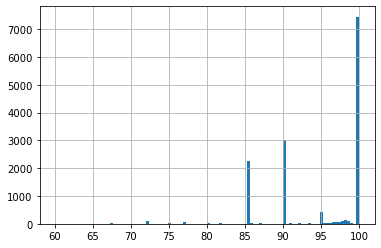

In [477]:
imdb_games["best_fit_ratio"].hist(bins=100)

We can see that we have a lot of values for 85, 90 and 100% matches. We've already ascertained that 90% does not seem to give accurate enough results. We are going to set the ratio at 92.5% (note, that this is done in the cell at the start of the notebook), which should be the best balance for accuracy. Now we remove any data from the merged columns where the ratio was below 92.5%

In [567]:
def remove_nonmatches(row):
    if row.best_fit_ratio < considered_best_fit_ratio:
        row.best_fit_game_id = np.nan
        row.game_id = np.nan
        row.franchise_id = np.nan
        row.developers = np.nan
        row.genres_y = np.nan
        row.platforms = np.nan
        row.publishers = np.nan
        row.rating = np.nan
    return row

In [568]:
imdb_games = imdb_games.apply(remove_nonmatches, axis = 1)

### AT THIS STAGE:

All the games with a very similar match ratio (92.5%) have the relevant franchise_ids applied to their data. The next thing to do will be to extract the franchise_ids match each franchise_id with the franchise name. To do this we need to import the franchise_dataframe

In [484]:
franchise_df = pd.read_csv("clean_franchise_ids.csv", index_col = 0)
franchise_df.sample()

,guid,name,description
45,3025-4306,Bloodstained,NaN


In [485]:
franchise_df.sample()

,guid,name,description
42,3025-5317,Among Us,NaN


In [486]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,best_fit_title,best_fit_ratio,best_fit_game_id,game_id,franchise_id,name,release_year,developers,genres_y,platforms,publishers,rating
368340,tt0384475,videoGame,Mega Man X7,Rockman X7,0,2003,"Action,Drama,Mystery",4.4,221.0,Rockman X7,Rockman X7,100.0,15563.0,12781.0,"[3025-524, 3025-523]",Mega Man X7,0,['Capcom Production Studio 3'],"['Action', 'Platformer']","['PlayStation 2', 'PC']",['Capcom'],"['ESRB: E', 'PEGI: 3+']"


In [569]:
imdb_games = imdb_games.explode("franchise_id")
imdb_games = pd.merge(imdb_games, franchise_df, left_on="franchise_id", right_on="guid", how="left")
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,best_fit_title,best_fit_ratio,best_fit_game_id,game_id,franchise_id,name_x,release_year,developers,genres_y,platforms,publishers,rating,guid,name_y,description
11891,tt2531922,videoGame,Mickey Mouse,Mickey Mouse,0,1981,\N,7.7,10.0,Mickey Mouse,Mickey Mouse,100.0,15876.0,13023.0,3025-535,Mickey Mouse,0,['Kemco'],"['Action', 'Platformer']",['Game Boy'],['Kemco'],NaN,3025-535,Mickey Mouse,"<h2>Overview</h2>Mickey Mouse is a cartoon character created by world-famous animator Walt Disney, in collaboration with his friend and business partner Ub Iwerks. Mickey was created to replace the earlier character of Oswald the Lucky Rabbit, who Disney's team did not control the rights to. With Mickey, Disney held onto the copyright and the intellectual property rights, so was able to spin the character out into a successful franchise.<br/><br/>In fact, Mickey Mouse is one of the <em>most</em> successful franchises of the 20th century. Aside from appearing in the first commercial successful ""animated talkie"", Mickey has been seen in dozens of other cartoons, numerous books, appeared in all of Disney's Resort locations and has been merchandised extensively. Mickey has appeared as everything from a cuddly toy to a wristwatch.<br/><br/>As part of the line of Mickey Mouse merchandise, DIsney have released a number of different Mickey-themed games, ranging from role-playing games to classic side-scrolling platformers."


Convert the genres_x to a list

In [571]:
imdb_games["genres_x"] = imdb_games["genres_x"].apply(lambda x: x.split(","))

In [615]:
type(imdb_games.genres_y.iloc[2])

list

In [614]:
#This line may or may not be needed depending on whether the type listed above is str or list (which will depend on how the dataframe was loaded)
imdb_games['genres_y'] = imdb_games["genres_y"].apply(lambda row: ast.literal_eval(row) if pd.notna(row) else np.nan)

Combine the genres columns and drop the extra one. Remove duplicates from each cell

In [616]:
imdb_games["genres_x"] = imdb_games["genres_x"] + imdb_games["genres_y"].fillna("").apply(list)
imdb_games = imdb_games.drop("genres_y", axis = 1)
imdb_games = imdb_games.rename(columns = {"genres_x": "genres"})

In [631]:
imdb_games['genres'] = imdb_games['genres'].apply(lambda x: list(set(x)))

In [623]:
cp = imdb_games.copy(deep=True)

In [632]:
imdb_games.sample()

,tconst,titleType,primaryTitle,isAdult,startYear,genres,averageRating,numVotes,best_fit_ratio,game_id,franchise_id,developers,platforms,publishers,rating,name_y
6697,tt11902930,videoGame,Overland,0,2019,"[Adventure, Action, Sci-Fi]",6.6,8.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [629]:
#Drop unnecessary columns
imdb_games =imdb_games.drop(["originalTitle", "all_names_x", "best_fit_title", "best_fit_game_id", "name_x", "release_year", "description", "guid"],  axis = 1)

In [633]:
#Rename franchise_name column
imdb_games = imdb_games.rename(columns = {"name_y": "franchise_name"})

In [634]:
# Rearrange the titles of the columns so the columns are in a better order:
imdb_games = imdb_games[["franchise_name", "franchise_id", "tconst", "titleType", "primaryTitle", "startYear", "isAdult", "averageRating", "numVotes", "game_id", "best_fit_ratio", "genres", "developers", "platforms", "publishers", "rating"]]
imdb_games.sample()

,franchise_name,franchise_id,tconst,titleType,primaryTitle,startYear,isAdult,averageRating,numVotes,game_id,best_fit_ratio,genres,developers,platforms,publishers,rating
15600,Pathfinder,3025-3911,tt7060582,videoGame,Pathfinder: Kingmaker,2018,0,7.2,127.0,15380.0,100.0,"[Adventure, Action, Role-Playing, Fantasy]",['Owlcat Games'],"['Mac', 'PC', 'Xbox One', 'PlayStation 4', 'Linux']",['Deep Silver'],NaN


Export the clean dataset to csv

In [635]:
imdb_games.to_csv("clean_games_with_franchises.csv")

# DONE TO HERE

In [337]:
copy_of_imdb_games2.guid.nunique()

2073

In [319]:
type(copy_of_imdb_games.genres_y.iloc[])

list

In [ ]:
#UNUSED  TO DELETE ##
copy_of_imdb_games2[((copy_of_imdb_games2['release_year'] != copy_of_imdb_games2['startYear']) & (copy_of_imdb_games2['release_year'] != "0"))].sort_values("tconst")

Merge any that have the same title and year

In [22]:
merged_games = pd.merge(imdb_games, giantbomb_games, left_on=['primaryTitle', 'startYear'], right_on=['name', 'release_year'], how='left')
merged_games.game_id.count()

664

In [23]:
additional_merged = pd.merge(imdb_games, giantbomb_games[~giantbomb_games.game_id.isin(merged_games.game_id)], left_on=['originalTitle', 'startYear'], right_on=['name', 'release_year'], how='inner')
merged_games = pd.concat([merged_games, additional_merged], axis=0)
merged_games.game_id.count()

683

In [393]:
merged_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_x,averageRating,numVotes,akas,game_id,franchise_id,name,release_year,aliases,developers,genres_y,platforms,publishers,rating
2604,tt10187046,videoGame,Cut the Rope: Experiments,Cut the Rope: Experiments,0,2011,\N,\N,"Adventure,Animation",6.1,22.0,['Cut the Rope: Experiments'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cleaning the genres: - Convert to list.

In [279]:
### UNUSED - TO REMOVE
def remove_nested_lists(entry):
    if pd.isna(entry):
        return entry
    else:
        return ast.literal_eval(entry)

copy_of_imdb_games["genres_y"] = copy_of_imdb_games["genres_y"].apply(lambda x: remove_nested_lists(x))

type(copy_of_imdb_games.genres_y.iloc[0])


list

In [ ]:
giantbomb_games

Having done this, we know that with any duplicates in our giantbomb, we'll have no way of distinguishing between them when it comes to combining them into our imdb dataset. If we try to combine by name, we'll be matching 2+ giantbomb games to a single imdb result. So we need to find a way to combine the giantbomb duplicates into a single entry. The other issue would be that we don't know from an imdb entry whether 

In [387]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas,all_names,best_matches,best_fit,best_fit_title,best_fit_ratio,best_fit_game_id
5857686,tt2290547,videoGame,Ninja-kun: Majô no Bôken,Ninja-kun: Majô no Bôken,0,1984,\N,\N,"Action,Fantasy",5.4,10.0,"['忍者くん魔城の冒険', 'Ninja-kun: Adventure of Devil C...",忍者くん魔城の冒険,[(Zelda II\nZelda 2: The Adventure of Link\nTh...,(Zelda II\nZelda 2: The Adventure of Link\nThe...,Zelda II\nZelda 2: The Adventure of Link\nThe ...,30.0,30997


In [388]:
giantbomb_games.sample()

,game_id,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating,all_names
22656,22656,[3025-1981],Thinkin' Things Collection 2,1994,[nan],['Edmark Corporation'],"['Educational', 'Puzzle']","['Mac', 'PC']",['Edmark Corporation'],NaN,Thinkin' Things Collection 2


In [ ]:
imdb_games[imdb_games.duplicated(subset = "primaryTitle", keep=False)]

In [ ]:
#dups = giantbomb_games[giantbomb_games.duplicated(subset='name', keep=False)]
#gb_duplicate_names = giantbomb_games[giantbomb_games.duplicated(subset='name', keep=False)] # all duplicate names
helpme = giantbomb_games[~giantbomb_games.game_id.isin(imdb_games.game_id)]

In [ ]:
helpme[helpme.duplicated(subset = "name", keep=False)]

In [ ]:
gb_duplicate_names = giantbomb_games.duplicated(subset='name', keep=False)
release_year_int = giantbomb_games['release_year'].astype(int).eq(0)
giantbomb_games = giantbomb_games.loc[~(gb_duplicate_names & release_year_int)]

In [ ]:
giantbomb_games.count()

In [ ]:
type(gb_duplicates)

Remove any duplicates from our giantbomb database where we have no record of the year of release

In [ ]:
gb_duplicate_names = giantbomb_games.duplicated(subset='name', keep=False)
release_year_int = giantbomb_games['release_year'].astype(int).eq(0)
gb_duplicates = giantbomb_games.loc[gb_duplicate_names & release_year_int]
#Having got all the duplicates with no release year, we'll drop them from the dataframe
giantbomb_games = giantbomb_games[~giantbomb_games.index.isin(gb_duplicates.index)]

In [ ]:
imdb_games = imdb_games[~imdb_games['tconst'].isin(imdb_duplicates['tconst'])]
imdb_games.tconst.count()

This leaves me with 13866 games in the imdb dataset to play with. The next step is to combine the imdb dataset with the giantbomb

In [ ]:
giantbomb_games.name.count()

In [ ]:
giantbomb_games.name.nunique()

The way I am going to do this is to first combine the rows where the year and name matches. Then combine any remaining rows where the name matches but the year doesn't match.

In [ ]:
giantbomb_games[giantbomb_games["game_id"] == 48320]

In [ ]:
copy_of_imdb_games = imdb_games
copy_of_giantbomb_games = giantbomb_games
print("Total imdb:{}, Total giantbomb:{}".format(copy_of_imdb_games.tconst.count(), copy_of_giantbomb_games.name.count()))

First get all the games that have a matching title and year. Merge them and remove from the original databases so they can't be used again.

In [ ]:
mergedDF = pd.DataFrame()

In [ ]:
mergedDF = pd.merge(copy_of_imdb_games, copy_of_giantbomb_games, left_on=["primaryTitle", "startYear"], right_on=["name", "release_year"], how="inner")
print("Total imdb: {}, Total giantbomb: {}, Total in df: {}".format(copy_of_imdb_games.tconst.count(), copy_of_giantbomb_games.name.count(), mergedDF.tconst.count()))

Now that we've matched the title and years, we'll drop any duplicates which contain years from the giantbomb data.

In [ ]:
copy_of_giantbomb_games = copy_of_giantbomb_games.drop_duplicates("name", keep=False)

In [ ]:
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
copied_imdb_mask.value_counts()

Now we have no duplicate names, we can attempt to match on just name, first with primaryTitle, then originalTitle

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["primaryTitle"], right_on=["name"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)

In [ ]:
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
copied_imdb_mask.value_counts()

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["originalTitle"], right_on=["name"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)

In [ ]:
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
copied_imdb_mask.value_counts()

In [ ]:
copied_giantbomb_mask.value_counts()

Now, check every possible alias in the giantbomb dataframe for a direct match.

In [ ]:
#Explode the aliases
copy_of_giantbomb_games = copy_of_giantbomb_games.explode("aliases")

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["primaryTitle"], right_on=["aliases"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)

In [ ]:
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
copied_imdb_mask.value_counts()

In [ ]:
copied_giantbomb_mask.value_counts()

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["originalTitle"], right_on=["aliases"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)

In [ ]:
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
copied_imdb_mask.value_counts()

In [ ]:
copied_giantbomb_mask.value_counts()

In [ ]:

copy_of_imdb_games['primaryTitle'] = copy_of_imdb_games['primaryTitle'].str.lower()
copy_of_imdb_games['originalTitle'] = copy_of_imdb_games['originalTitle'].str.lower()

copy_of_giantbomb_games['name'] = copy_of_giantbomb_games['name'].str.lower()
copy_of_giantbomb_games['aliases'] = copy_of_giantbomb_games['aliases'].str.lower()

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["primaryTitle"], right_on=["name"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["originalTitle"], right_on=["name"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])
print(copied_imdb_mask.value_counts())

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["primaryTitle"], right_on=["aliases"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])
print(copied_imdb_mask.value_counts())

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["originalTitle"], right_on=["aliases"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])
print(copied_imdb_mask.value_counts())

In [ ]:
import re
temp = mergedDF[mergedDF["name"].str.contains("Sherlock", na=False, flags=re.IGNORECASE, regex=True)]
temp

In [ ]:
#Explode the akas

copy_of_imdb_games = copy_of_imdb_games.explode("akas")

In [ ]:
copy_of_imdb_games['akas'] = copy_of_imdb_games['akas'].str.lower()

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["akas"], right_on=["name"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])
print(copied_imdb_mask.value_counts())

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games[~copied_imdb_mask], copy_of_giantbomb_games[~copied_giantbomb_mask], left_on=["akas"], right_on=["aliases"], how="inner")
mergedDF = pd.concat([mergedDF, mergedDF2], axis=0)
copied_imdb_mask = copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])
copied_giantbomb_mask = copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])
print(copied_imdb_mask.value_counts())

Create a function that combines all the possible names including akas, into a list foe each imdb entry

In [ ]:
nonmatched_imdb = copy_of_imdb_games[~copied_imdb_mask]
nonmatched_gb = copy_of_giantbomb_games[~copied_giantbomb_mask]

In [ ]:
def imdb_all_names(imdb_row):
    imdb_row_list = [imdb_row.primaryTitle, imdb_row.originalTitle]
    if type(imdb_row.akas) ==str:
        akas_list = ast.literal_eval(imdb_row.akas)
        for x in akas_list:
            imdb_row_list.append(x)
    return imdb_row_list

In [ ]:
nonmatched_imdb['all_names'] = nonmatched_imdb.apply(lambda row: imdb_all_names(row), axis=1)
nonmatched_imdb

In [ ]:
nonmatched_gb['all_names'] = nonmatched_gb.apply(lambda row: gb_all_names(row), axis=1)
nonmatched_gb

In [ ]:
def gb_all_names(gb_row):
    gb_row_list = [gb_row["name"]]
    for alias in gb_row.aliases:
        if type(alias) == str:
            gb_row_list.append(alias) 
    return gb_row_list

In [ ]:
nonmatched_imdb['all_names'] = nonmatched_imdb['all_names'].apply(lambda x: list(set(x)))
nonmatched_gb['all_names'] = nonmatched_gb['all_names'].apply(lambda x: list(set(x)))

In [ ]:
nonmatched_imdb = nonmatched_imdb.explode("all_names")
nonmatched_gb = nonmatched_gb.explode("all_names")

In [ ]:

nonmatched_gb = nonmatched_gb.explode("all_names")
nonmatch_gb_list = nonmatched_gb.all_names.to_list()

In [ ]:
def get_top_unmatches(imdb_row):
    return process.extract(imdb_row.all_names, nonmatch_gb_list, limit = 3)

In [ ]:
time_at_start = time.perf_counter()
nonmatched_imdb['best_matches'] = nonmatched_imdb.apply(lambda row: get_top_unmatches(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
nonmatched_imdb

In [ ]:
time_at_start = time.perf_counter()
nonmatched_imdb['best_fit'] = nonmatched_imdb.apply(lambda row: best_fit(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
time_at_start = time.perf_counter()
nonmatched_imdb[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = nonmatched_imdb['best_fit'].apply(lambda x: pd.Series([i for i in x]))
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
nonmatched_imdb = nonmatched_imdb.sort_values(["best_fit_ratio"])
nonmatched_imdb

In [ ]:
nonmatched_imdb["best_fit_ratio"].value_counts()

In [ ]:
nonmatched_imdb = nonmatched_imdb[nonmatched_imdb['best_fit_ratio'] >= 80]
nonmatched_imdb

In [ ]:
copy_of_imdb_games['all_names'] = copy_of_imdb_games.apply(lambda row: imdb_all_names(row), axis=1)
copy_of_imdb_games

Combine all giantbomb possible names including aliases.

In [ ]:
def gb_all_names(gb_row):
    gb_row_list = [gb_row["name"]]
    for alias in gb_row.aliases:
        if type(alias) == str:
            gb_row_list.append(alias) 
    return gb_row_list


In [ ]:
copy_of_giantbomb_games['all_names'] = copy_of_giantbomb_games.apply(lambda row: gb_all_names(row), axis=1)
copy_of_giantbomb_games

Remove any duplicates in all the name lists

In [ ]:
copy_of_imdb_games['all_names'] = copy_of_imdb_games['all_names'].apply(lambda x: list(set(x)))
copy_of_giantbomb_games['all_names'] = copy_of_giantbomb_games['all_names'].apply(lambda x: list(set(x)))

In [ ]:
copy_of_giantbomb_games.sample()

In [ ]:
copy_of_imdb_games.drop(["best_matches", "best_fit", "best_fit_title", "best_fit_ratio", "best_fit_game_id"])

## Attempt to use rapidFuzz

This seems to be the fastest way we can fuzzymatch across the entire dataframe (that I have found). We first explode all the giantbomb names, and the imdb names. Then convert the giantbomb names to a list. We can then run rapidfuzz for all the names in our imdb dataset against the giantbomb list and append the results to a best_matches column in our imdb dataframe. Once we have this we can 

In [ ]:
copy_of_imdb_games = copy_of_imdb_games[~copied_imdb_mask].explode("all_names")
copy_of_giantbomb_games = copy_of_giantbomb_games[~copied_giantbomb_mask].explode("all_names")

In [ ]:
giantbomb_remaining_list = copy_of_giantbomb_games.all_names.to_list()

In [ ]:
from rapidfuzz import process, fuzz

In [ ]:
def get_top_matches(imdb_row):
    return process.extract(imdb_row.all_names, giantbomb_remaining_list, limit = 3)

In [ ]:
import time

In [ ]:
time_at_start = time.perf_counter()
copy_of_imdb_games['best_matches'] = copy_of_imdb_games.apply(lambda row: get_top_matches(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt0383279"]

In [ ]:
print(copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt0383279"]["best_matches"].iloc[0])
print(copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt0383279"]["best_matches"].iloc[1])
print(copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt0383279"]["best_matches"].iloc[2])

In [ ]:
type(copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt0383279"]["best_matches"].iloc[0][0][0])

In [ ]:
def best_fit(row):
    highest = 0
    best_match = ()
    for match in row["best_matches"]:
        if match[1] > highest:
            highest = match[1]
            best_match = match
    return best_match

In [ ]:
time_at_start = time.perf_counter()
copy_of_imdb_games['best_fit'] = copy_of_imdb_games.apply(lambda row: best_fit(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
copy_of_imdb_games[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = copy_of_imdb_games['best_fit'].apply(lambda x: pd.Series([i for i in x]))


In [ ]:
copy_of_imdb_games = copy_of_imdb_games[copy_of_imdb_games['best_fit_ratio'] >= 90.5]

In [ ]:
copy_of_imdb_games =copy_of_imdb_games.sort_values(["tconst", "best_fit_ratio"])
copy_of_imdb_games.head(50)

In [ ]:
small_imdb_exploded['best_fit'] = small_imdb_exploded.apply(lambda row: best_fit(row), axis = 1)


In [ ]:
small_imdb_exploded[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = small_imdb_exploded['best_fit'].apply(lambda x: pd.Series([i for i in x]))

    

In [ ]:
frame = copy_of_imdb_games[copy_of_imdb_games["tconst"]=="tt7025920"]
frame

In [ ]:
copy_of_giantbomb_games.game_id.count()

In [ ]:
copy_of_imdb_games.to_csv("copy_of_imdb_games.csv")

In [ ]:
copy_of_imdb_games = pd.read_csv("copy_of_imdb_games.csv")

In [ ]:
copy_of_imdb_games['best_matches'] = copy_of_imdb_games["best_matches"].apply(lambda row: ast.literal_eval(row))
type(copy_of_imdb_games["best_matches"].iloc[0])

In [ ]:
copy_of_imdb_games

In [ ]:
copy_of_imdb_games['best_fit'] = copy_of_imdb_games.apply(lambda row: best_fit(row), axis = 1)
copy_of_imdb_games[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = copy_of_imdb_games['best_fit'].apply(lambda x: pd.Series([i for i in x]))
copy_of_imdb_games = copy_of_imdb_games.sort_values("best_fit_ratio")
copy_of_imdb_games

In [ ]:
copy_of_imdb_games = copy_of_imdb_games.sort_values("best_fit_ratio")

In [ ]:
copy_of_imdb_games[copy_of_imdb_games["tconst"] == "tt11696274"].iloc[1]["best_matches"]

In [ ]:
copy_of_giantbomb_games[copy_of_giantbomb_games.index == 18179]

In [ ]:
copy_of_imdb_games[copy_of_imdb_games["tconst"] == "tt11696274"]

In [ ]:
copy_of_giantbomb_games

In [ ]:
mergedDF[mergedDF["game_id"] == 48320]

In [ ]:
copy_of_giantbomb_games[copy_of_giantbomb_games["game_id"] == "48320"]

In [ ]:
copy_of_imdb_games[(copy_of_imdb_games["best_fit_ratio"] >97) &  (copy_of_imdb_games["best_fit_ratio"] <98)].head(50)

In [ ]:
import numpy as np

In [ ]:
small_imdb_exploded['best_matches'] = small_imdb_exploded.apply(lambda row: get_top_matches(row), axis = 1)


In [ ]:
small_imdb_exploded

In [ ]:
small_imdb_exploded["best_matches"].iloc[0]

In [ ]:
def withlist(imdb_row):
    results_list = process.extract(imdb_row.all_names, giantbomb_list, limit = 3)
    return results_list

In [ ]:
import time
time_at_start = time.perf_counter()
small_imdb_exploded['best_matches'] = small_imdb_exploded.apply(lambda row: withlist(row), axis=1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
small_imdb_exploded

In [ ]:
giantbomb_exploded.iloc[22642]

In [ ]:
small_imdb_exploded.best_matches.iloc[0]

In [ ]:
def rapidfuzzymatch(imdb_row):
    results_list = []
    for index, row in giantbomb_games.iterrows():
        distances  = process.cdist(row["all_names"], imdb_row.all_names, score_cutoff = 87)
        top_indices = np.argsort(distances, axis=1)
        top_values = imdb_row[top_indices]
        print(top_values)
            
            #for result in results:
                #Get tuple value if above 95
            #    if result[1]>87:
            #        results_list.append(set([row["game_id"], row["name"], result[1]]))
    return results_list

In [ ]:
import time
time_at_start = time.perf_counter()
small_imdb['best_matches'] = small_imdb.apply(lambda row: rapidfuzzymatch(row), axis=1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
small_imdb.best_matches.iloc[0]

## Attempting to use fuzzy matching

The next step is to attempt to fuzzy match the titles and the original titles from the imdb dataset against the giantbomb database

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Fuzzy match attempt

In [ ]:
def fuzzymatch(imdb_row):
    results_list = []
    for index, row in giantbomb_games.iterrows():
        for item in row["all_names"]:
            results = process.extract(item, imdb_row.all_names, limit = 3)
            for result in results:
                #Get tuple value if above 95
                if result[1]>87:
                    results_list.append(set([row["game_id"], row["name"], result[1]]))
    return results_list


Testing on single entry

In [ ]:
small_imdb = imdb_games[imdb_games["tconst"]== "tt7990520"]
small_imdb

In [ ]:
import time
time_at_start = time.perf_counter()
small_imdb['best_matches'] = small_imdb.apply(lambda row: fuzzymatch(row), axis=1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

In [ ]:
small_imdb.best_matches.iloc[0]

In [ ]:
small_imdb

### Next attempt, explode the dataframes, then do fuzzymatch

In [ ]:
small_imdb_exploded = small_imdb.explode("all_names")

In [ ]:
small_imdb_exploded

In [ ]:
def fuzzymatch_exploded(imdb_row):
    results_list = []
    for index, row in giantbomb_exploded.iterrows():
        results = process.extract(row["all_names"], imdb_row.all_names, limit = 3)
        for result in results:
            #Get tuple value if above 95
            if result[1]>87:
                results_list.append(set([row["game_id"], row["name"], result[1]]))
    return results_list

In [ ]:
imdb_exploded = imdb_games.explode("all_names")
imdb_exploded.count()

In [ ]:
giantbomb_exploded = giantbomb_games.explode("all_names")
giantbomb_exploded.count()

In [ ]:
import time
time_at_start = time.perf_counter()
small_imdb['exploded_best_matches'] = small_imdb.apply(lambda row: fuzzymatch_exploded(row), axis=1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

## Attempting to use difflib

In [ ]:
string =small_imdb_exploded.all_names.iloc[0]
close_matches = difflib.get_close_matches(string, possibilities=giantbomb_exploded['all_names'].tolist(), n=10)


In [ ]:
close_matches

In [ ]:
# https://stackoverflow.com/questions/56521625/quicker-way-to-perform-fuzzy-string-match-in-pandas

import difflib
from functools import partial

f = partial(difflib.get_close_matches, possibilities=giantbomb_exploded['all_names'].tolist(), n=1)

matches = small_imdb_exploded['all_names'].map(f).str[0].fillna('')
scores = [difflib.SequenceMatcher(None, x, y).ratio() 
    for x, y in zip(matches, small_imdb['all_names'])
]

small_imdb.assign(best=matches, score=scores)

# Consider exploding the all_names, then combining back but keeping the one with the best ratio?

## First attempt to merge, purely using dataframes

In [ ]:
mergedDF = pd.merge(copy_of_imdb_games, copy_of_giantbomb_games, left_on=["primaryTitle", "startYear"], right_on=["name", "release_year"], how="inner")
#copy_of_imdb_games = copy_of_imdb_games[~copy_of_imdb_games['tconst'].isin(mergedDF['tconst'])]
#copy_of_giantbomb_games = copy_of_giantbomb_games[~copy_of_giantbomb_games['game_id'].isin(mergedDF['game_id'])]
print("Total imdb: {}, Total giantbomb: {}, Total in df: {}".format(copy_of_imdb_games.tconst.count(), copy_of_giantbomb_games.name.count(), mergedDF.tconst.count()))

In [ ]:
Now match any where the names directly match, and the release_year is 0

In [ ]:
mergedDF2 = pd.merge(copy_of_imdb_games, copy_of_giantbomb_games[copy_of_giantbomb_games['release_year'] == "0"], left_on="primaryTitle", right_on="name", how="inner")
copy_of_imdb_games = copy_of_imdb_games[~copy_of_imdb_games['tconst'].isin(mergedDF2['tconst'])]
copy_of_giantbomb_games = copy_of_giantbomb_games[~copy_of_giantbomb_games['game_id'].isin(mergedDF2['game_id'])]
print("Total imdb: {}, Total giantbomb: {}, Total in df2: {}".format(copy_of_imdb_games.tconst.count(), copy_of_giantbomb_games.name.count(), mergedDF2.tconst.count()))

In [ ]:
mergedDF2[mergedDF2["primaryTitle"]=="Alice in Wonderland"]

In [ ]:
mergedDF3 = pd.merge(copy_of_imdb_games, copy_of_giantbomb_games, left_on="originalTitle", right_on="name", how="inner")
copy_of_imdb_games = copy_of_imdb_games[~copy_of_imdb_games['tconst'].isin(mergedDF3['tconst'])]
copy_of_giantbomb_games = copy_of_giantbomb_games[~copy_of_giantbomb_games['game_id'].isin(mergedDF3['game_id'])]
print("Total imdb: {}, Total giantbomb: {}, Total in df3: {}".format(copy_of_imdb_games.tconst.count(), copy_of_giantbomb_games.name.count(), mergedDF3.tconst.count()))

In [ ]:
mergedDF4 = pd.concat([mergedDF, mergedDF2, mergedDF3], axis=0)
mergedDF4

In [ ]:
temp = imdb_duplicates[~(imdb_duplicates["primaryTitle"]== imdb_duplicates["originalTitle"])]

In [ ]:
temp = pd.merge(imdb_duplicates, giantbomb_games, left_on=['primaryTitle'], right_on=['name'], how='inner')
temp

In [ ]:
giantbomb_games.sort_values("game_id").head()

In [ ]:
tempdb = pd.merge(imdb_duplicates, giantbomb_games, left_on=['primaryTitle'], right_on=['name'], how='inner')
tempdb

In [ ]:
for index1 in imdb_duplicates.primaryTitle:
    #rint(index1)
    value = fuzz.token_sort_ratio("bction 2", index1)
    if value > 80:
        print(index1)
        print(value)

In [ ]:
imdb_duplicates.head(500)

In [ ]:
for index1 in imdb_duplicates.primaryTitle:
    #rint(index1)
    value = fuzz.token_sort_ratio("bction 2", index1)
    if value > 80:
        print(index1)
        print(value)

In [ ]:
imdb_duplicates

In [ ]:
imdb_duplicates = imdb_duplicates[imdb_duplicates['primaryTitle'].isin(giantbomb_games['name'])]
imdb_duplicates

Create dictionary with count for each duplicate

In [ ]:
imdb_duplicate_counts

In [ ]:
imdb_duplicate_counts = imdb_duplicates.groupby('primaryTitle').size()
imdb_duplicate_dict = {k:v for k,v in imdb_duplicate_counts.items() if v > 1}
imdb_duplicate_dict

In [ ]:
giantbomb_games[giantbomb_games["name"] == "Worms"]


Note here, we are only going to consider direct matches of a name for brevity's sake. If giantbomb contains no records that match the name of an imdb duplicate, we will assume the duplicates are not part of a franchise.

In [ ]:
for key, value in imdb_duplicate_dict.items():
    if giantbomb_games.name[giantbomb_games["name"] == key].count() == 0:
        # Game is not a franchise game, and can be kept in original imdb dataframe
        print(key)
        #imdb_duplicates = imdb_duplicates.drop(index=imdb_duplicates.index[imdb_duplicates['primaryTitle'] == key])
imdb_duplicates.count()

In [ ]:
imdb_duplicates.count()

In [ ]:
Action 52 is not in giantbomb games so we can keep in our original database as it's a unique game. Therefore we need to drop it from our dups dataframe

This leaves us with 411 duplicates, which exist in the imdb database but we may not be able to accurately match them with the 

WE ARE CREATING A DUPS DATAFRAME WHICH WILL BE ALL THE DUPLICATES WE CAN'T DISTINGUISH BETWENN. IF WE CAN DISTINGUISH, WE DROP FROM THE DUPS DATABASE. IF IMDB GAMES NAME DOES NOT APPEAR IN GIANTBOMB GAMES NAME, DROP FROM DUPLICATES LIST

sO FAR WE HAVE DONE ENOUGH. wE JUST NEED TO DO FUZZY MATCHING ON THE NAMES TO COMPARE.EG. ADAM'S VENTURE EXISTS IN BOTH BUT NEEDS FUZZY MATCHING AGAINST ORIGINAL TITLE

In [ ]:
imdb_duplicates = imdb_duplicates[~imdb_duplicates['tconst'].isin(matching_imdb_dups['tconst'])]


In [ ]:
for key, value in imdb_duplicate_dict.items():
    if giantbomb_games.name[giantbomb_games["name"] == key].count() == 0:
        # Game is not a franchise game, and can be kept in original imdb dataframe
        imdb_duplicates = imdb_duplicates.drop(index=imdb_duplicates.index[imdb_duplicates['primaryTitle'] == key])
    elif giantbomb_games.name[giantbomb_games["name"] == key].count() != value:
        #matching_ids holds index values of duplicates
        matching_imdb_ids=imdb_duplicates.index[imdb_duplicates['primaryTitle'] == key]
        matching_gb_ids = giantbomb_games.index[giantbomb_games['name'] == key]
        if 
        #for id in matching_imdb_ids:
            #This extracts the year
         #   year =imdb_duplicates.startYear[imdb_duplicates.index[imdb_duplicates.index == id]].item()
          #  if giantbomb_games.name[giantbomb_games["name"] == key] and giantbomb_games.release_year[giantbomb_games["release_year"] == year]:
           #     for 
            #    print("Great success!", year)
           # else:
            #    print("poo")
        
        print(key, value, giantbomb_games.name[giantbomb_games["name"] == key].count())

In [ ]:
giantbomb_games[giantbomb_games.duplicated(["name"], keep=False)].count()

In [ ]:
import re
temp = imdb_games[imdb_games["primaryTitle"].str.contains("Batman", na=False, flags=re.IGNORECASE, regex=True)]
temp

In [ ]:
import re
temp2 = giantbomb_games[giantbomb_games["name"].str.contains("Adam's", na=False, flags=re.IGNORECASE, regex=True)]
temp2

In [ ]:
duplicate_giantbomb_names = giantbomb_games[giantbomb_games.duplicated(["name", "release_year"], keep=False)]
duplicate_giantbomb_names = duplicate_giantbomb_names.sort_values("name")
duplicate_giantbomb_names

Get list of all game_ids

In [ ]:
game_id_list = duplicate_giantbomb_names.index.to_list()

for each item in the list, get the corresponding json file. Clean to extract necessary data (esp. year)

In [ ]:
for game_id, api_url in game_api_dict.items():
    filename = "{}.json".format(game_id)
    if not Path(game_dir, filename).is_file():

        

In [ ]:
print(len(release_years))

In [ ]:
num_nans = id_year_df.isna().sum().sum()
print(num_nans)

In [ ]:
# group the data by name and count the number of occurrences
grouped = giantbomb_games.groupby(['name']).size().reset_index(name='count')

# select the rows where count > 1, indicating a duplicate name
duplicates = grouped[grouped['count'] > 1]

# select the rows with duplicate name and different game_id
duplicates = giantbomb_games[giantbomb_games['name'].isin(duplicates['name'])].groupby('name').filter(lambda x: x['game_id'].nunique() > 1)

# print the duplicate rows, sorted by name
if len(duplicates) > 0:
    print("Found {} rows with same name but different game_id:".format(len(duplicates)))
    print(duplicates.sort_values(by=['name', 'game_id']))
else:
    print("No rows with same name but different game_id found.")


In [ ]:
temp2 = temp[temp.duplicated(["name", "index"], keep=False)]
temp2 = temp2.sort_values("name")
temp2

In [ ]:
a = giantbomb_games[giantbomb_games["name"].str.contains('Sqrxz', na=False, flags=re.IGNORECASE, regex=True)]
a

The first thing I am going to do is check for any titles that appear only once in both dataframes and that have matching titles. With this criteria, we can assume that the games are the same. 

In [ ]:
unmatching_rows = imdb_games[~imdb_games['primaryTitle'].isin(giantbomb_games['name'])]

In [ ]:
try_this = unmatching_rows[unmatching_rows['originalTitle'].isin(giantbomb_games['name'])]
try_this.count()

In [ ]:
import re
temp = giantbomb_games[giantbomb_games["name"].str.contains('Infernal', na=False, flags=re.IGNORECASE, regex=True)]
temp.head(50)

My current plan for the most accurate way to approach this:

First check for duplicate names in both datasets. If there is a duplicate name in either dataset, we need to check whether this is because there are 2 games with the same name. If this is the case, we need a way to distinguish between the 2. I would anticipate year of release could work.

The next step would be comparing names against alternate titles. After this, any that still have no matches, would be subject to fuzzy matching.I'd anticipate at least 75% of the games in the imdb dataset should be contained in giantbomb's database.

In [ ]:
imdb_dups = imdb_games[imdb_games.duplicated(['primaryTitle', 'startYear'], keep=False)]
imdb_dups = imdb_dups.sort_values("primaryTitle")
print(imdb_dups)